#Library and Dependencies


In [31]:
import re
import nltk
import wordcloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, Callback
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam

from google.colab import drive

In [2]:
!pip install tweet-preprocessor
import preprocessor as p

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

#Data preparation

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#source : https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis?select=twitter_training.csv
df = pd.read_csv('/content/drive/MyDrive/resource_machine_learning/twitter_training.csv', names=['tweet_id', 'entity', 'sentiment','text'])

In [6]:
df

,tweet_id,entity,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


#EDA

In [7]:
df.dtypes

tweet_id      int64
entity       object
sentiment    object
text         object
dtype: object

In [8]:
df['sentiment'].value_counts()

Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: sentiment, dtype: int64

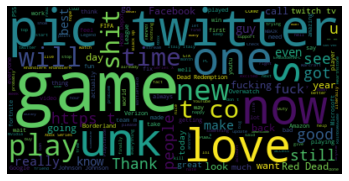

In [32]:
common_words=''
for i in df.text:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Preprocessing Data

In [9]:
def clean_text(text):
  emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # Kode Emoticon
        u'\U0001F300-\U0001F5FF'  # Kode symbols & pictograph
        u'\U0001F680-\U0001F6FF'  # Kode transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # Kode flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
  text = p.clean(text)
  text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
  text = emoji_pattern.sub(r'', text)
  text = text.lower()
  return text

In [10]:
def removing_stopwords(text):
  text = " ".join([word for word in text.split() if word not in stop_words])
  return text

In [11]:
def lemmatizing_text(text):
  text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
  return text

In [12]:
df['text'] = df['text'].apply(str)
df['cleaned_text'] = df['text'].apply(lambda x: clean_text(x)) #clean and lowercase text 
lemmatizer = WordNetLemmatizer()
df['lemma_text'] = df['cleaned_text'].apply(lambda x: lemmatizing_text(x)) #lemmatizing word
stop_words = set(stopwords.words("english"))
df['final_text'] = df['lemma_text'].apply(lambda x: removing_stopwords(x)) #removing stopword

In [13]:
df.head(100)

,tweet_id,entity,sentiment,text,cleaned_text,lemma_text,final_text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting on borderlands and i will murder yo...,im getting on borderland and i will murder you...,im getting borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...,i am coming to the border and i will kill you all,coming border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you all,im getting on borderland and i will kill you all,im getting borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...,im coming on borderland and i will murder you all,im coming borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting on borderlands and i will murder yo...,im getting on borderland and i will murder you...,im getting borderland murder
...,...,...,...,...,...,...,...
95,2416,Borderlands,Neutral,I hate that this easy horrible modifier event ...,i hate that this easy horrible modifier event ...,i hate that this easy horrible modifier event ...,hate easy horrible modifier event game last fo...
96,2417,Borderlands,Negative,Grounded almost looked pretty cool even despit...,grounded almost looked pretty cool even despit...,grounded almost looked pretty cool even despit...,grounded almost looked pretty cool even despit...
97,2417,Borderlands,Negative,Grounded looked cool despite the borderline un...,grounded looked cool despite the borderline un...,grounded looked cool despite the borderline un...,grounded looked cool despite borderline unfunn...
98,2417,Borderlands,Negative,"Grosskreutz looked pretty cool, even despite t...",grosskreutz looked pretty cool even despite th...,grosskreutz looked pretty cool even despite th...,grosskreutz looked pretty cool even despite un...


#Feature selection and engineering

In [14]:
category = pd.get_dummies(df.sentiment)
df_baru = pd.concat([df['final_text'], category], axis=1)
df_baru

,final_text,Irrelevant,Negative,Neutral,Positive
0,im getting borderland murder,0,0,0,1
1,coming border kill,0,0,0,1
2,im getting borderland kill,0,0,0,1
3,im coming borderland murder,0,0,0,1
4,im getting borderland murder,0,0,0,1
...,...,...,...,...,...
74677,realized window partition mac like year behind...,0,0,0,1
74678,realized mac window partition year behind nvid...,0,0,0,1
74679,realized window partition mac year behind nvid...,0,0,0,1
74680,realized window partition mac like year behind...,0,0,0,1


In [63]:
text = df_baru['final_text'].values
label = df_baru[['Irrelevant', 'Negative', 'Neutral', 'Positive']].values

In [75]:
text_train, text_val, label_train, label_val = train_test_split(text, label, test_size=0.2, random_state=42)

In [76]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train) 
tokenizer.fit_on_texts(text_val)
 
sequences_train = tokenizer.texts_to_sequences(text_train)
sequences_val = tokenizer.texts_to_sequences(text_val)
 
text_train = pad_sequences(sequences_train, maxlen=200, truncating='pre') 
text_val = pad_sequences(sequences_val, maxlen=200, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 31996


#Modeling and training

In [77]:
embeddings_index = {}
embedding_dim = 200
hits = 0
misses = 0
num_tokens = vocabSize

with open('/content/drive/MyDrive/resource-tugas/Assignment/glove.6B.200d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 17328 words (14667 misses)


In [86]:
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90 and logs.get('val_accuracy')>0.85):
      print("\nAkurasi diatas 90% dengan validasi diatas 86%, hentikan training!")
      self.model.stop_training = True
callback = myCallback()

In [87]:
model = Sequential([
  Embedding(
        num_tokens, 
        embedding_dim,
        input_length=200,
        weights = [embedding_matrix],
        trainable=False 
        ),
  LSTM(512),
  Dropout(0.5),
  Dense(64),
  Dropout(0.5),
  Dense(16),
  Dropout(0.5),
  Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', 
              optimizer= Adam(learning_rate=0.0005), 
              metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 200, 200)          6399200   
                                                                 
 lstm_12 (LSTM)              (None, 512)               1460224   
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 64)                32832     
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 16)                1040      
                                                                 
 dropout_22 (Dropout)        (None, 16)              

In [88]:
history = model.fit(text_train, label_train, epochs=100, batch_size=128, validation_data=(text_val, label_val), verbose=1, callbacks=[callback])

Epoch 1/100
  6/467 [..............................] - ETA: 41s - loss: 1.4584 - accuracy: 0.2969

467/467 [==============================] - 43s 88ms/step - loss: 1.2553 - accuracy: 0.4451 - val_loss: 1.1376 - val_accuracy: 0.5183
Epoch 2/100
467/467 [==============================] - 40s 86ms/step - loss: 1.2520 - accuracy: 0.4865 - val_loss: 1.2634 - val_accuracy: 0.4471
Epoch 3/100
467/467 [==============================] - 40s 86ms/step - loss: 1.2330 - accuracy: 0.4598 - val_loss: 1.1139 - val_accuracy: 0.5269
Epoch 4/100
467/467 [==============================] - 41s 87ms/step - loss: 1.1361 - accuracy: 0.5235 - val_loss: 1.0665 - val_accuracy: 0.5498
Epoch 5/100
467/467 [==============================] - 41s 87ms/step - loss: 1.0768 - accuracy: 0.5565 - val_loss: 1.0119 - val_accuracy: 0.5776
Epoch 6/100
467/467 [==============================] - 40s 87ms/step - loss: 1.0261 - accuracy: 0.5816 - val_loss: 0.9631 - val_accuracy: 0.6047
Epoch 7/100
467/467 [==============================] - 40s 86ms/step - loss: 0.9639 - accuracy: 0.6150 - val_loss: 0.8963 - val_accuracy: 0.63

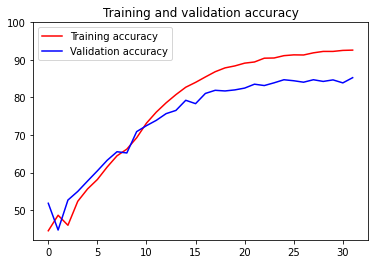

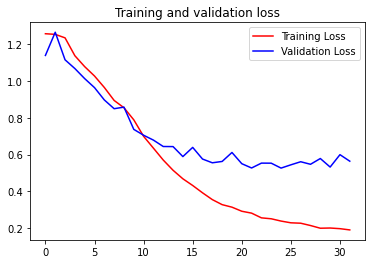

In [90]:
%matplotlib inline
acc = [x*100 for x in history.history['accuracy']]
val_acc = [x*100 for x in history.history['val_accuracy']]
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.ylim(top=100)
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()